<a href="https://colab.research.google.com/github/szymonczaja/Home-credit-default-risk/blob/main/Home_deafult_credit_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Celem niniejszego projektu jest przeprowadzenie predykcji ryzyka udzielenia klientowi pozyczki bankowej na podstawie jego historii bankowej. Jako hipoteze wstępną mogę przyjąć, że na ocene ryzyka najwiekszy wplyw bedzie mial dochod klienta, historia kredytowa tzn. czy dany klient terminowo wywiązywał sie z platnosci zobowiązań do banku oraz czy klient splaca aktualnie inny kredyt oraz scoring kredytowy daneg klienta.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import optuna
import shap

In [ ]:
X_train = pd.read_csv('application_train.csv')
X_train2 = pd.read_csv('application_train.csv') #wczutuje jeszcze raz dane bo X_train uzylem recznie do wyznaczenia wartosci odstajacyh i wizualizacji, X_train2 bedzie surowym df ktory poddam działaniu CustomTransformatora
X_test = pd.read_csv('application_test.csv')

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194129 entries, 0 to 194128
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(103), int64(3), object(16)
memory usage: 180.7+ MB


In [ ]:
X_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
corr = X_train.select_dtypes(include=np.number).corr()['TARGET'].sort_values()
print(f'Najsilniejsze negatywne korelacje: {corr.head(15)}')
print(f'Najsiliejsze pozytywne korelacje: {corr.tail(15)}')

Najsilniejsze negatywne korelacje: EXT_SOURCE_3                 -0.175775
EXT_SOURCE_2                 -0.161175
EXT_SOURCE_1                 -0.152739
FLOORSMAX_AVG                -0.047645
FLOORSMAX_MEDI               -0.047643
FLOORSMAX_MODE               -0.046557
DAYS_EMPLOYED                -0.043959
FLOORSMIN_AVG                -0.041170
FLOORSMIN_MEDI               -0.041100
AMT_GOODS_PRICE              -0.040032
FLOORSMIN_MODE               -0.039565
REGION_POPULATION_RELATIVE   -0.038117
ELEVATORS_AVG                -0.037079
ELEVATORS_MEDI               -0.036751
ELEVATORS_MODE               -0.034834
Name: TARGET, dtype: float64
Najsiliejsze pozytywne korelacje: DEF_60_CNT_SOCIAL_CIRCLE       0.033774
DEF_30_CNT_SOCIAL_CIRCLE       0.033858
LIVE_CITY_NOT_WORK_CITY        0.033978
OWN_CAR_AGE                    0.040039
DAYS_REGISTRATION              0.040112
REG_CITY_NOT_LIVE_CITY         0.041996
FLAG_DOCUMENT_3                0.043667
FLAG_EMP_PHONE                 0.0449

In [ ]:
X_train.shape

(194129, 122)

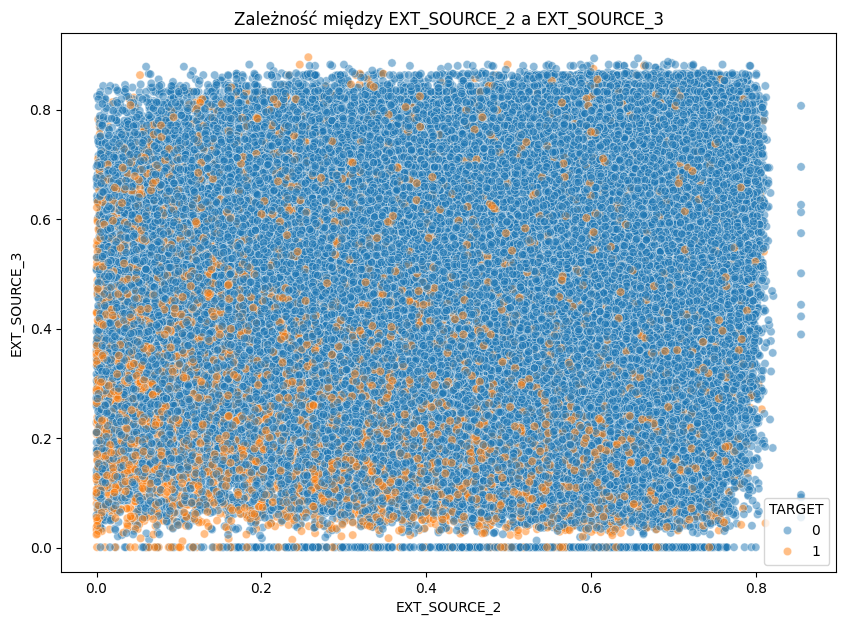

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='EXT_SOURCE_2', y='EXT_SOURCE_3', hue='TARGET', data=X_train, alpha=0.5)
plt.title('Zależność między EXT_SOURCE_2 a EXT_SOURCE_3')
plt.show()

EXT_SOURCE to kolumny które mówią nam o scoringu danego klienta w zewnętrznych bazach scoringowych, jak widać na wykresie powyżej największe zgrupowanie klientów z targetem = 1 (pomarańczowe punkty) czyli osób z problamami finansowymi znajdują się przy przy niskich wartościach dwóch współczynników scoringowych

Columns to do:
EXT_SOURCE_MEAN,
EXT_SOURCE_MIN,
EXT_SOURE_MAX?,
EXT_SOURCE_PRODUCT

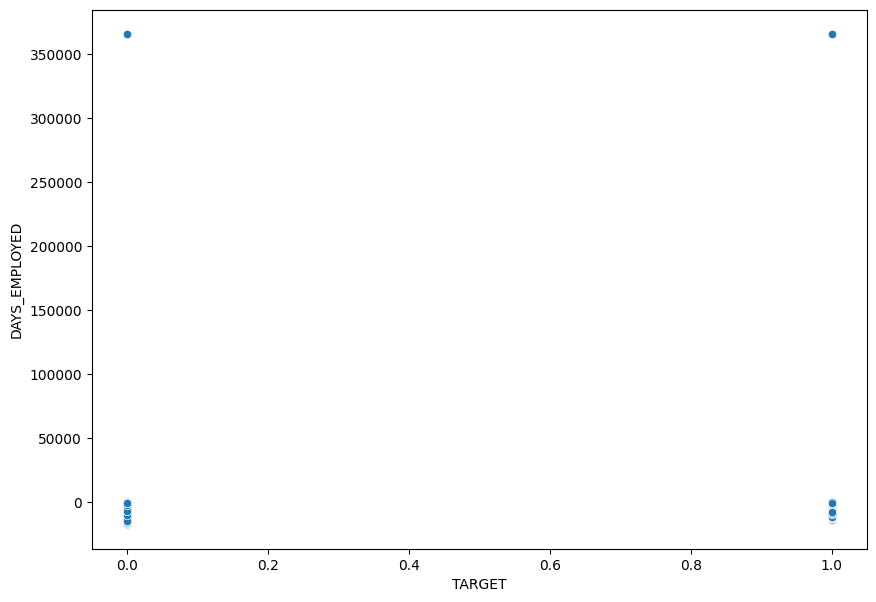

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='TARGET', y='DAYS_EMPLOYED', data=X_train)
plt.show()

In [ ]:
(X_train['DAYS_EMPLOYED'] > 350000).value_counts()

,count
DAYS_EMPLOYED,
False,159184
True,34945


In [ ]:
X_train['DAYS_EMPLOYED_ANOM'] = (X_train['DAYS_EMPLOYED'] > 350000)
print(X_train.groupby(['DAYS_EMPLOYED_ANOM'])['TARGET'].mean())

DAYS_EMPLOYED_ANOM
False    0.087006
True     0.055001
Name: TARGET, dtype: float64


Wśród osób z anomalią odsetek osób z problemami ze spłatą zoobowiązań wobec banku jest niski.

In [ ]:

X_train.loc[X_train['DAYS_EMPLOYED'] > 350000, 'DAYS_EMPLOYED'] = np.nan

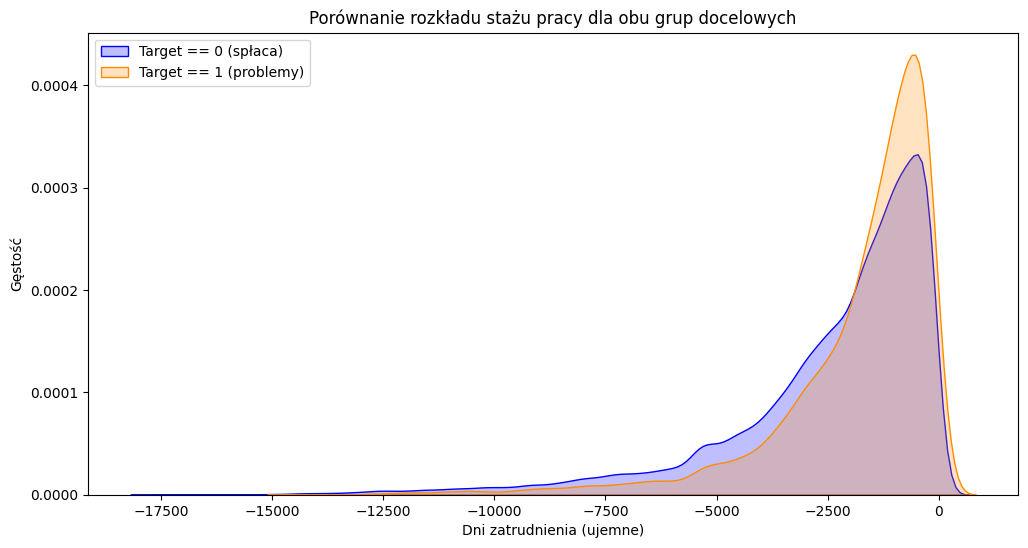

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_EMPLOYED'],
            label='Target == 0 (spłaca)',
            color='blue', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_EMPLOYED'],
            label='Target == 1 (problemy)',
            color='darkorange', fill=True)

plt.xlabel('Dni zatrudnienia (ujemne)')
plt.ylabel('Gęstość')
plt.title('Porównanie rozkładu stażu pracy dla obu grup docelowych')
plt.legend()
plt.show()

Porównując te dwie krzywe, widzimy, że są one wyraźnie przesunięte względem siebie. Szczyt koncentracji dla osób z problemami jest w innym miejscu niż dla osób bez problemów. Co oznacza, że krótszy staż pracy jest silnie powiązany z ryzykiem nie spłacenia pożyczki przez klienta banku.

Wartości dni zatrudnienia są ujemne bo oznaczają ilość dni pracy przed apikacją klienta o pożyczke.

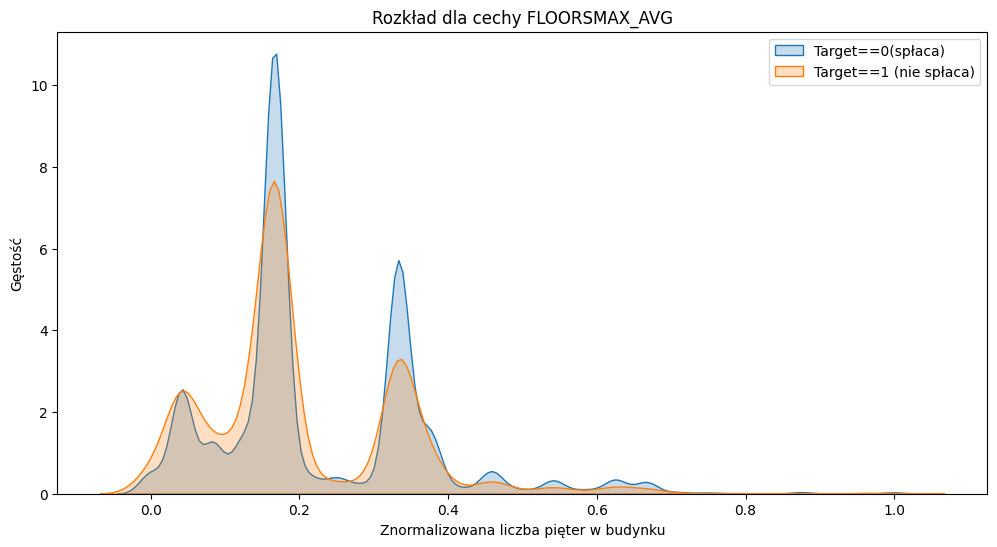

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'FLOORSMAX_AVG'],
            label='Target==0(spłaca)', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET']==1, 'FLOORSMAX_AVG'],
            label='Target==1 (nie spłaca)', fill=True)
plt.title('Rozkład dla cechy FLOORSMAX_AVG')
plt.xlabel('Znormalizowana liczba pięter w budynku')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

Obie krzywe niebieska i pomarańczowa pokrywają się w dużym stopniu oznacza to, że rozkład wartości cechy FLOORSMAX_AVG jest taki sam dla klientow którzy spłacają pożyczki i dla którzy tych pożyczek nie spłacają.
Cecha jest słabym predyktorem, nie pomaga nam odróżnić od siebie klientów którzy spłacają a tych którzy nie spłacają na podstawie liczby pięter.

Wykres jest potwierdzeniem niskiego wyniku korelacji który uzyskaliśmy pomiedzy TARGET a FLOORSMAX_AVG

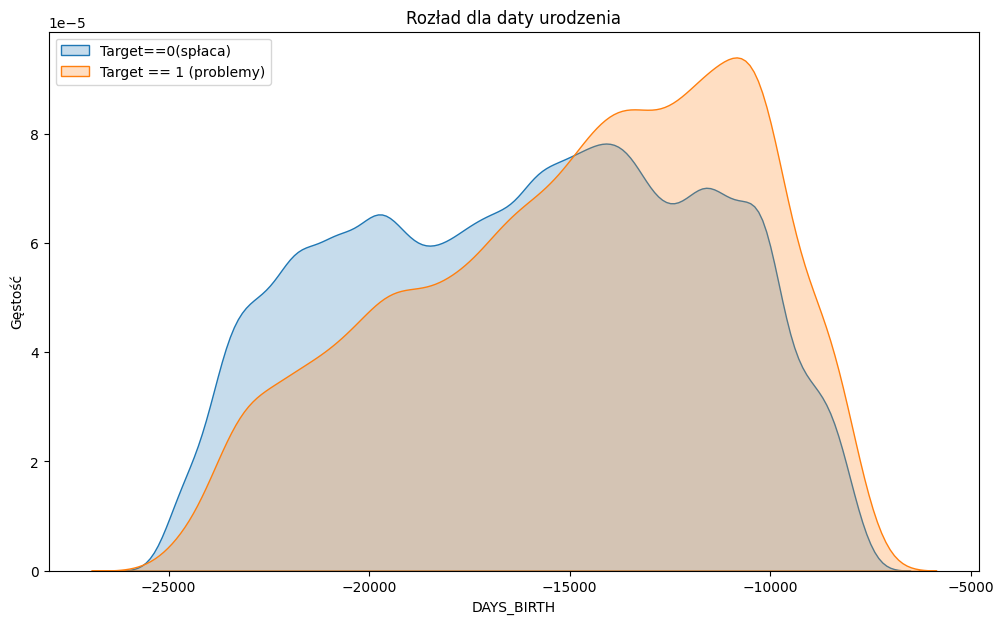

In [ ]:
#wykres zaleznosci pomiędzy problemami ze splata lub ie a dat urodzenia klienta banku
plt.figure(figsize=(12, 7))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_BIRTH'],
            label='Target==0(spłaca)', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET']==1, 'DAYS_BIRTH'],
            label='Target == 1 (problemy)', fill=True)

plt.title('Rozład dla daty urodzenia')
plt.xlabel('DAYS_BIRTH')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

Jak widac na wykresie klienci z problemami ze spłatą są statystycznie młodsi o czym informuje nas pomaranczowy wierzchołek przesunięty w lewo.
Klienci którzy spłacają bez problemowo swoje zobowiązania są statystycznie starsi.

w skrócie młodsi są grupą o wyższym ryzyku kredytowym jest to silna cecha predykcyjna.

In [ ]:
X_train['REGION_RATING_CLIENT_W_CITY'].value_counts()

,count
REGION_RATING_CLIENT_W_CITY,
2.0,144763
3.0,27757
1.0,21608


In [ ]:
region_probs = X_train.groupby('REGION_RATING_CLIENT_W_CITY')['TARGET'].mean()

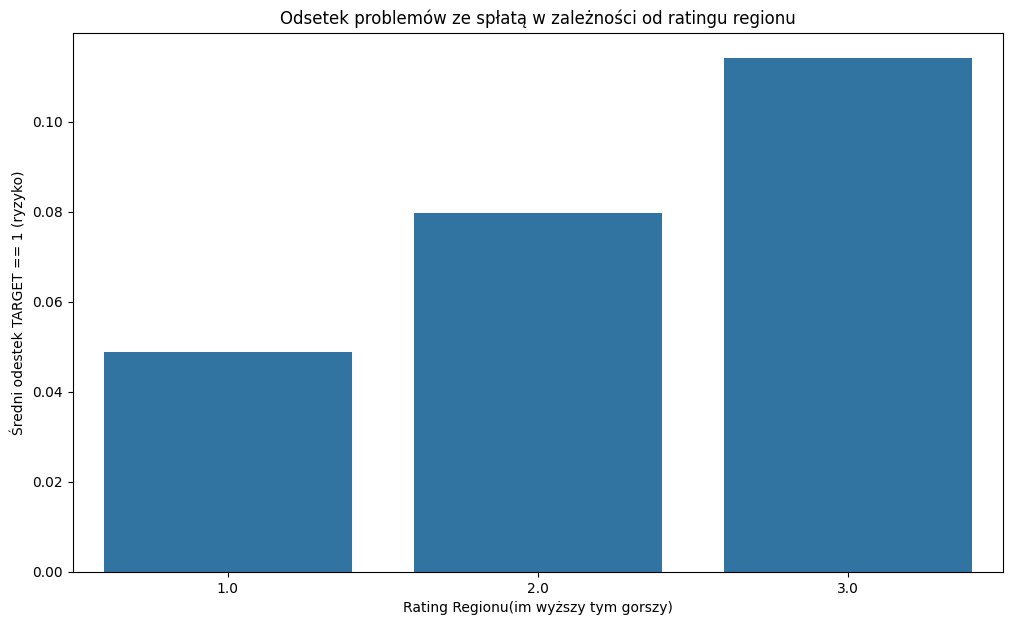

In [ ]:
plt.figure(figsize=(12, 7))
sns.barplot(x=region_probs.index, y=region_probs.values)
plt.title('Odsetek problemów ze spłatą w zależności od ratingu regionu')
plt.xlabel('Rating Regionu(im wyższy tym gorszy)')
plt.ylabel('Średni odestek TARGET == 1 (ryzyko)')
plt.show()

Jak widać na wykresie im gorszy rating regionu w jakim klient mieszka tym większy odsetek klientów dla których udzielenie pozyczki bedzie ryzykowne i potencjalnie bed emogly wynikac z tego problemy.

Rating regionu jest silną cechą predykcyjną.

In [ ]:
X_train['DAYS_LAST_PHONE_CHANGE'].value_counts()

,count
DAYS_LAST_PHONE_CHANGE,
0.0,23859
-1.0,1761
-2.0,1460
-3.0,1144
-4.0,812
...,...
-3153.0,1
-3533.0,1
-4026.0,1


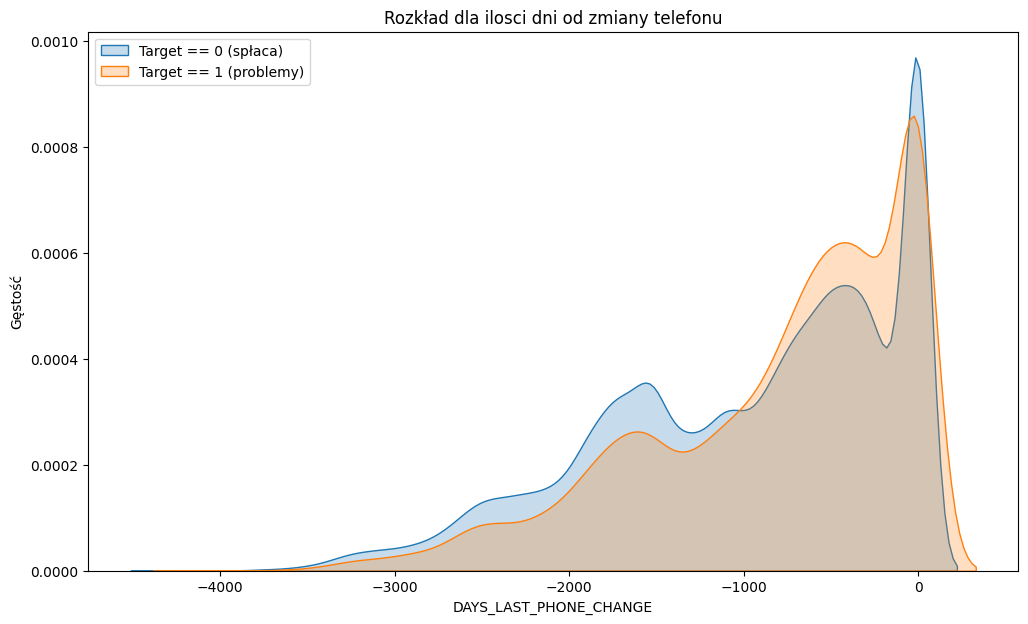

In [ ]:
plt.figure(figsize=(12, 7))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_LAST_PHONE_CHANGE'],
            label='Target == 0 (spłaca)', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_LAST_PHONE_CHANGE'],
            label='Target == 1 (problemy)', fill=True)

plt.title('Rozkład dla ilosci dni od zmiany telefonu')
plt.xlabel('DAYS_LAST_PHONE_CHANGE')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

Brak istotnego wpływu na ryzyko udzielenia kredytu, rozklady identyczne dla osób z problemami i klientami bez problemów w spłacie kredytu.

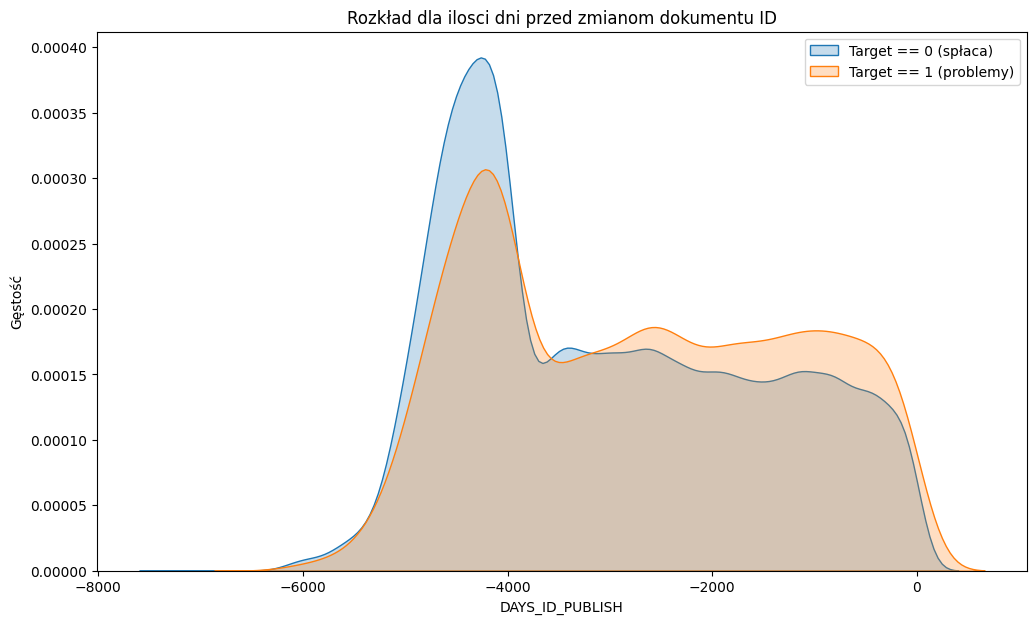

In [ ]:
plt.figure(figsize=(12, 7))
sns.kdeplot(X_train.loc[X_train['TARGET'] == 0, 'DAYS_ID_PUBLISH'],
            label='Target == 0 (spłaca)', fill=True)

sns.kdeplot(X_train.loc[X_train['TARGET'] == 1, 'DAYS_ID_PUBLISH'],
            label='Target == 1 (problemy)', fill=True)

plt.title('Rozkład dla ilosci dni przed zmianom dokumentu ID')
plt.xlabel('DAYS_ID_PUBLISH')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

In [ ]:
bureau = pd.read_csv('bureau.csv')

In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131.0,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20.0,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16.0,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16.0,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21.0,NaN


In [ ]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793639 entries, 0 to 793638
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SK_ID_CURR              793639 non-null  int64  
 1   SK_ID_BUREAU            793639 non-null  int64  
 2   CREDIT_ACTIVE           793639 non-null  object 
 3   CREDIT_CURRENCY         793639 non-null  object 
 4   DAYS_CREDIT             793639 non-null  int64  
 5   CREDIT_DAY_OVERDUE      793639 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     744635 non-null  float64
 7   DAYS_ENDDATE_FACT       499532 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  272009 non-null  float64
 9   CNT_CREDIT_PROLONG      793639 non-null  int64  
 10  AMT_CREDIT_SUM          793633 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     674079 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    519120 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  793638 non-null  float64
 14  CREDIT_TYPE         

Kolumna SK_ID_CURR łączy bureau z application_train/test

In [ ]:
bureau['CREDIT_ACTIVE'].value_counts()

,count
CREDIT_ACTIVE,
Closed,497943
Active,292644
Sold,3043
Bad debt,9


Kolumna do potencjalnego one hot encodingu

In [ ]:
bureau['CREDIT_CURRENCY'].value_counts()

,count
CREDIT_CURRENCY,
currency 1,793003
currency 2,556
currency 3,75
currency 4,5


tak samo pojdzie do OneHotEncoder()

In [ ]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'AMT_CREDIT_SUM': ['sum', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean']
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
bureau_status_counts = bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts(normalize=True).unstack(fill_value=0)
bureau_status_counts.columns = ['BUREAU_STATUS_' + str(col).upper() for col in bureau_status_counts.columns]

bureau_full_agg = bureau_agg.join(bureau_status_counts, how='left', on='SK_ID_CURR')

X_train_with_bureau = X_train.join(bureau_full_agg, how='left', on='SK_ID_CURR')
X_train_with_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_STATUS_ACTIVE,BUREAU_STATUS_BAD DEBT,BUREAU_STATUS_CLOSED,BUREAU_STATUS_SOLD
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-103.0,-817.833333,347555.565,57925.9275,0.0,0.0,0.166667,0.0,0.833333,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-408.0,-867.000000,189037.800,94518.9000,0.0,0.0,0.000000,0.0,1.000000,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_app = pd.read_csv('previous_application.csv')
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
prev_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68319 entries, 0 to 68318
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_PREV                   68319 non-null  int64  
 1   SK_ID_CURR                   68319 non-null  int64  
 2   NAME_CONTRACT_TYPE           68319 non-null  object 
 3   AMT_ANNUITY                  53820 non-null  float64
 4   AMT_APPLICATION              68319 non-null  float64
 5   AMT_CREDIT                   68319 non-null  float64
 6   AMT_DOWN_PAYMENT             33645 non-null  float64
 7   AMT_GOODS_PRICE              53550 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   68319 non-null  object 
 9   HOUR_APPR_PROCESS_START      68319 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  68319 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       68319 non-null  int64  
 12  RATE_DOWN_PAYMENT            33645 non-null  float64
 13  RATE_INTEREST_PR

In [ ]:
prev_app['APP_CREDIT_RATIO'] = prev_app['AMT_CREDIT'] / prev_app['AMT_APPLICATION']
prev_app['APP_CREDIT_RATIO'] = prev_app['APP_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan)
prev_app['APP_CREDIT_RATIO'] = prev_app['APP_CREDIT_RATIO'].fillna(0)

prev_app_status_pct = prev_app.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].value_counts(normalize=True).unstack(fill_value=0)
prev_app_status_pct.columns = ['PREV_APP_STATUS_' + str(col).upper() for col in prev_app_status_pct.columns]

prev_app_num_agg = prev_app.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'max'],
    'APP_CREDIT_RATIO': ['mean', 'max']
})

prev_app_num_agg.columns = ['PREV_APP_' + '_'.join(col).upper() for col in prev_app_num_agg.columns]
prev_app_full_agg = prev_app.join(prev_app_num_agg, how='left', on='SK_ID_CURR')
prev_app_full_agg.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,APP_CREDIT_RATIO,PREV_APP_AMT_APPLICATION_MEAN,PREV_APP_AMT_APPLICATION_MAX,PREV_APP_APP_CREDIT_RATIO_MEAN,PREV_APP_APP_CREDIT_RATIO_MAX
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,-42.0,300.0,-42.0,-37.0,0.0,1.00000,17145.0,17145.0,1.00000,1.00000
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,-134.0,916.0,365243.0,365243.0,1.0,1.11880,607500.0,607500.0,1.11880,1.11880
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,-271.0,59.0,365243.0,365243.0,1.0,1.21284,112500.0,112500.0,1.21284,1.21284
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,-482.0,-152.0,-182.0,-177.0,1.0,1.04620,450000.0,450000.0,1.04620,1.04620
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,1.19720,337500.0,337500.0,1.19720,1.19720


In [ ]:
installments_pay = pd.read_csv('installments_payments.csv')
installments_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674.0,1.0,6.0,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639.0,0.0,34.0,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053.0,2.0,1.0,-63.0,-63.0,25425.000,25425.000
3,2452527,199697.0,1.0,3.0,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756.0,1.0,2.0,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
installments_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591867 entries, 0 to 591866
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SK_ID_PREV              591867 non-null  int64  
 1   SK_ID_CURR              591866 non-null  float64
 2   NUM_INSTALMENT_VERSION  591866 non-null  float64
 3   NUM_INSTALMENT_NUMBER   591866 non-null  float64
 4   DAYS_INSTALMENT         591866 non-null  float64
 5   DAYS_ENTRY_PAYMENT      591866 non-null  float64
 6   AMT_INSTALMENT          591866 non-null  float64
 7   AMT_PAYMENT             591866 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 36.1 MB


In [ ]:
installments_pay['PAYMENT_DELAY'] = installments_pay['DAYS_ENTRY_PAYMENT'] - installments_pay['DAYS_INSTALMENT']
installments_pay['PAYMENT_DIFFERENCE'] = installments_pay['AMT_INSTALMENT'] - installments_pay['AMT_PAYMENT']
installments_pay_agg = installments_pay.groupby('SK_ID_CURR').agg({
    'PAYMENT_DELAY': ['mean', 'max', lambda x: (x > 0).sum()],
    'PAYMENT_DIFFERENCE': ['mean', 'max', lambda x: (x>0).sum()]
})

installments_pay_agg.columns = pd.Index([
    'INSTALLMENTS_DELAY_MEAN',
    'INSTALLMENTS_DELAY_MAX',
    'INSTALLMENTS_DELAY_COUNT',
    'INSTALLMENTS_DIFFERENCE_MEAN',
    'INSTALLMENTS_DIFFERENCE_MAX',
    'INSTALLMENTS_DIFFERENCE_COUNT'
])
installments_pays_full_agg = installments_pay.join(installments_pay_agg, how='left', on='SK_ID_CURR')
installments_pays_full_agg.head()


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAYMENT_DELAY,PAYMENT_DIFFERENCE,INSTALLMENTS_DELAY_MEAN,INSTALLMENTS_DELAY_MAX,INSTALLMENTS_DELAY_COUNT,INSTALLMENTS_DIFFERENCE_MEAN,INSTALLMENTS_DIFFERENCE_MAX,INSTALLMENTS_DIFFERENCE_COUNT
0,1054186,161674.0,1.0,6.0,-1180.0,-1187.0,6948.360,6948.360,-7.0,0.000,-10.875000,0.0,0.0,0.000000,0.000,0.0
1,1330831,151639.0,0.0,34.0,-2156.0,-2156.0,1716.525,1716.525,0.0,0.000,-1.285714,2.0,3.0,4.643036,130.005,1.0
2,2085231,193053.0,2.0,1.0,-63.0,-63.0,25425.000,25425.000,0.0,0.000,11.500000,23.0,1.0,0.000000,0.000,0.0
3,2452527,199697.0,1.0,3.0,-2418.0,-2426.0,24350.130,24350.130,-8.0,0.000,1.000000,10.0,2.0,5.100000,15.300,1.0
4,2714724,167756.0,1.0,2.0,-1383.0,-1366.0,2165.040,2160.585,17.0,4.455,1.333333,17.0,5.0,456.925000,2156.625,6.0


In [ ]:
credit_card_balance = pd.read_csv('credit_card_balance.csv')
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0.0,0.0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0.0,0.0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0.0,0.0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0.0,0.0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0.0,0.0


In [ ]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393869 entries, 0 to 393868
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_PREV                  393869 non-null  int64  
 1   SK_ID_CURR                  393869 non-null  int64  
 2   MONTHS_BALANCE              393869 non-null  int64  
 3   AMT_BALANCE                 393869 non-null  float64
 4   AMT_CREDIT_LIMIT_ACTUAL     393869 non-null  int64  
 5   AMT_DRAWINGS_ATM_CURRENT    308898 non-null  float64
 6   AMT_DRAWINGS_CURRENT        393869 non-null  float64
 7   AMT_DRAWINGS_OTHER_CURRENT  308898 non-null  float64
 8   AMT_DRAWINGS_POS_CURRENT    308898 non-null  float64
 9   AMT_INST_MIN_REGULARITY     365185 non-null  float64
 10  AMT_PAYMENT_CURRENT         308522 non-null  float64
 11  AMT_PAYMENT_TOTAL_CURRENT   393869 non-null  float64
 12  AMT_RECEIVABLE_PRINCIPAL    393869 non-null  float64
 13  AMT_RECIVABLE 

In [ ]:
credit_card_balance['PAYMENT_DIFFERENCE'] = credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] - credit_card_balance['AMT_PAYMENT_CURRENT']
credit_card_balance['ATM_DRAWNINGS_RATIO'] = credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] / credit_card_balance['AMT_DRAWINGS_CURRENT']
credit_card_balance['ATM_DRAWNINGS_RATIO'] = credit_card_balance['ATM_DRAWNINGS_RATIO'].replace([np.inf, -np.inf], np.nan)

credit_agg = credit_card_balance.groupby('SK_ID_CURR').agg({
     'AMT_BALANCE': ['mean', 'max'],
     'ATM_DRAWNINGS_RATIO': ['mean', 'max'],
     'SK_DPD': ['mean', 'max', lambda x: (x>0).sum()],
     'PAYMENT_DIFFERENCE': ['mean', 'max', lambda x: (x<0).sum()]
})

credit_agg.columns = pd.Index([
    'AMT_BALANCE_MEAN',
    'AMT_BALANCE_MAX',
    'ATM_DRAWNINGS_RATIO_MEAN',
    'ATM_DRAWNINGS_RATIO_MAX',
    'SK_DPD_MEAN',
    'SK_DPD_MAX',
    'SK_DPD_COUNT',
    'PAYMENT_DIFFERENCE_MEAN',
    'PAYMENT_DIFFERENCE_MAX',
    'PAYMENT_DIFFERENCE_COUNT'
])

credit_card_full_agg = credit_card_balance.join(credit_agg, how='left', on='SK_ID_CURR')
credit_card_full_agg.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_BALANCE_MEAN,AMT_BALANCE_MAX,ATM_DRAWNINGS_RATIO_MEAN,ATM_DRAWNINGS_RATIO_MAX,SK_DPD_MEAN,SK_DPD_MAX,SK_DPD_COUNT,PAYMENT_DIFFERENCE_MEAN,PAYMENT_DIFFERENCE_MAX,PAYMENT_DIFFERENCE_COUNT
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,11385.776250,45328.320,0.000000,0.0,0.000000,0.0,0,0.000000,0.0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,49642.260000,70475.850,1.000000,1.0,0.000000,0.0,0,-7.095000,0.0,1
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,73248.401250,134691.795,NaN,NaN,0.000000,0.0,0,0.000000,0.0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,236572.110000,236572.110,1.000000,1.0,0.000000,0.0,0,0.000000,0.0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,215394.893182,459959.130,0.270359,1.0,0.090909,1.0,1,-195.803182,0.0,1


In [ ]:
credit_card_full_agg['PAYMENT_DIFFERENCE_COUNT'].value_counts()

,count
PAYMENT_DIFFERENCE_COUNT,
0,174639
1,37568
2,27858
3,24381
4,23226
5,21373
6,19594
7,17152
8,13959


In [ ]:
class CustomTransformator(TransformerMixin, BaseEstimator):
  def __init__(self):
    self.bureau = pd.read_csv('bureau.csv')
    self.prev_app = pd.read_csv('previous_application.csv')
    self.installments_pay = pd.read_csv('installments_payments.csv')
    self.credit_card_balance = pd.read_csv('credit_card_balance.csv')

  def fit(self, X, y=None):
    return self

  def _process_bureau(self, df_input) -> pd.DataFrame:
    df = df_input.copy()
    bureau_agg = self.bureau.groupby('SK_ID_CURR').agg({
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'AMT_CREDIT_SUM': ['sum', 'mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean']
    })
    bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]
    bureau_status_counts = self.bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts(normalize=True).unstack(fill_value=0)
    bureau_status_counts.columns = ['BUREAU_STATUS_' + str(col).upper() for col in bureau_status_counts.columns]
    bureau_full_agg = bureau_agg.join(bureau_status_counts, how='left', on='SK_ID_CURR')
    df = df.join(bureau_full_agg, how='left', on='SK_ID_CURR')
    return df

  def _process_application(self, df_input) -> pd.DataFrame:
    df = df_input.copy()
    prev_app_copy = self.prev_app.copy()
    prev_app_copy['APP_CREDIT_RATIO'] = prev_app_copy['AMT_CREDIT'] / prev_app_copy['AMT_APPLICATION']
    prev_app_copy['APP_CREDIT_RATIO'] = prev_app_copy['APP_CREDIT_RATIO'].replace([np.inf, -np.inf], np.nan)
    prev_app_copy['APP_CREDIT_RATIO'] =  prev_app_copy['APP_CREDIT_RATIO'].fillna(0)
    prev_app_status_pct = prev_app_copy.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].value_counts(normalize=True).unstack(fill_value=0)
    prev_app_status_pct.columns = ['PREV_APP_STATUS_' + str(col).upper() for col in prev_app_status_pct.columns]
    prev_app_num_agg = prev_app_copy.groupby('SK_ID_CURR').agg({
        'AMT_APPLICATION': ['mean', 'max'],
        'APP_CREDIT_RATIO': ['mean', 'max']
    })
    prev_app_num_agg.columns = ['PREV_APP_' + '_'.join(col).upper() for col in prev_app_num_agg.columns]
    prev_app_full_agg = prev_app_status_pct.join(prev_app_num_agg, how='left', on='SK_ID_CURR')
    df = df.join(prev_app_full_agg, how='left', on='SK_ID_CURR')
    return df

  def _process_application_features(self, df_input) -> pd.DataFrame:
    '''
    Przetwarza i tworzy nowe cechy z głównej tabeli application.csv
    '''
    df = df_input.copy()
    df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] > 350000).astype(int)
    df.loc[df['DAYS_EMPLOYED'] > 350000, 'DAYS_EMPLOYED'] = np.nan
    return df

  def _process_installments(self, df_input):
    df = df_input.copy()
    installments_pay_copy = self.installments_pay.copy()
    installments_pay_copy['PAYMENT_DELAY'] = installments_pay_copy['DAYS_ENTRY_PAYMENT'] - installments_pay_copy['DAYS_INSTALMENT']
    installments_pay_copy['PAYMENT_DIFFERENCE'] = installments_pay_copy['AMT_INSTALMENT'] - installments_pay_copy['AMT_PAYMENT']
    installments_pay_agg = installments_pay_copy.groupby('SK_ID_CURR').agg({
        'PAYMENT_DELAY': ['mean', 'max', lambda x: (x > 0).sum()],
        'PAYMENT_DIFFERENCE': ['mean', 'max', lambda x: (x>0).sum()]
    })
    installments_pay_agg.columns = pd.Index([
        'INSTALLMENTS_DELAY_MEAN',
        'INSTALLMENTS_DELAY_MAX',
        'INSTALLMENTS_DELAY_COUNT',
        'INSTALLMENTS_DIFFERENCE_MEAN',
        'INSTALLMENTS_DIFFERENCE_MAX',
        'INSTALLMENTS_DIFFERENCE_COUNT'
    ])
    df = df.join(installments_pay_agg, how='left', on='SK_ID_CURR')
    return df

  def _process_credit_card(self, df_input) -> pd.DataFrame:
    df = df_input.copy()
    credit_card_balance_copy = self.credit_card_balance.copy()
    credit_card_balance_copy['PAYMENT_DIFFERENCE'] = credit_card_balance_copy['AMT_PAYMENT_TOTAL_CURRENT'] - credit_card_balance_copy['AMT_PAYMENT_CURRENT']
    credit_card_balance_copy['ATM_DRAWNINGS_RATIO'] = credit_card_balance_copy['AMT_DRAWINGS_ATM_CURRENT'] / credit_card_balance_copy['AMT_DRAWINGS_CURRENT']
    credit_card_balance_copy['ATM_DRAWNINGS_RATIO'] = credit_card_balance_copy['ATM_DRAWNINGS_RATIO'].replace([np.inf, -np.inf], np.nan)

    credit_agg = credit_card_balance_copy.groupby('SK_ID_CURR').agg({
        'AMT_BALANCE': ['mean', 'max'],
        'ATM_DRAWNINGS_RATIO': ['mean', 'max'],
        'SK_DPD': ['mean', 'max', lambda x: (x>0).sum()],
        'PAYMENT_DIFFERENCE': ['mean', 'max', lambda x: (x<0).sum()]
    })

    credit_agg.columns = pd.Index([
        'AMT_BALANCE_MEAN',
        'AMT_BALANCE_MAX',
        'ATM_DRAWNINGS_RATIO_MEAN',
        'ATM_DRAWNINGS_RATIO_MAX',
        'SK_DPD_MEAN',
        'SK_DPD_MAX',
        'SK_DPD_COUNT',
        'PAYMENT_DIFFERENCE_MEAN',
        'PAYMENT_DIFFERENCE_MAX',
        'PAYMENT_DIFFERENCE_COUNT'
    ])
    df = df.join(credit_agg, how='left', on='SK_ID_CURR')
    return df


  def transform(self, X) -> pd.DataFrame:
    df = X.copy()
    df = self._process_bureau(df)
    df = self._process_application(df)
    df = self._process_installments(df)
    df = self._process_credit_card(df)
    df = self._process_application_features(df)
    return df



In [ ]:
feature_transformator = CustomTransformator()
X_train_raw_transformed = feature_transformator.transform(X_train)

In [ ]:
y_raw = X_train_raw_transformed['TARGET']

In [ ]:
new_corr = X_train_raw_transformed.select_dtypes(include=np.number).corr()['TARGET'].sort_values()
print(f'Najsilniejsze korelacje pozytywne: {new_corr.tail(15)}')
print(f'Najsilniejsze korelacje negatywne: {new_corr.head(15)}')

Najsilniejsze korelacje pozytywne: REG_CITY_NOT_WORK_CITY         0.050687
DAYS_ID_PUBLISH                0.051992
DAYS_LAST_PHONE_CHANGE         0.055460
REGION_RATING_CLIENT           0.058246
PREV_APP_STATUS_REFUSED        0.059071
AMT_BALANCE_MAX                0.059889
REGION_RATING_CLIENT_W_CITY    0.060407
BUREAU_STATUS_ACTIVE           0.066795
BUREAU_DAYS_CREDIT_MIN         0.070632
AMT_BALANCE_MEAN               0.071496
DAYS_EMPLOYED                  0.074703
DAYS_BIRTH                     0.078457
BUREAU_DAYS_CREDIT_MEAN        0.079508
TARGET                         1.000000
DAYS_EMPLOYED_ANOM                  NaN
Name: TARGET, dtype: float64
Najsilniejsze korelacje negatywne: EXT_SOURCE_3                 -0.175775
EXT_SOURCE_2                 -0.161175
EXT_SOURCE_1                 -0.152739
BUREAU_STATUS_CLOSED         -0.067869
PREV_APP_STATUS_APPROVED     -0.050941
FLOORSMAX_AVG                -0.047645
FLOORSMAX_MEDI               -0.047643
FLOORSMAX_MODE              

Jak widać na wykazie korelacji pomiedzy cechami a TARGET, az 7 kolumn które utworzyłem weszło do top 15 korelacji negatywnych i pozytywnych. Oznacza to, że dodałem do zbioru cechy które będą silymi predyktorami targetu.

In [ ]:
X_train_raw_transformed.shape

(194129, 158)

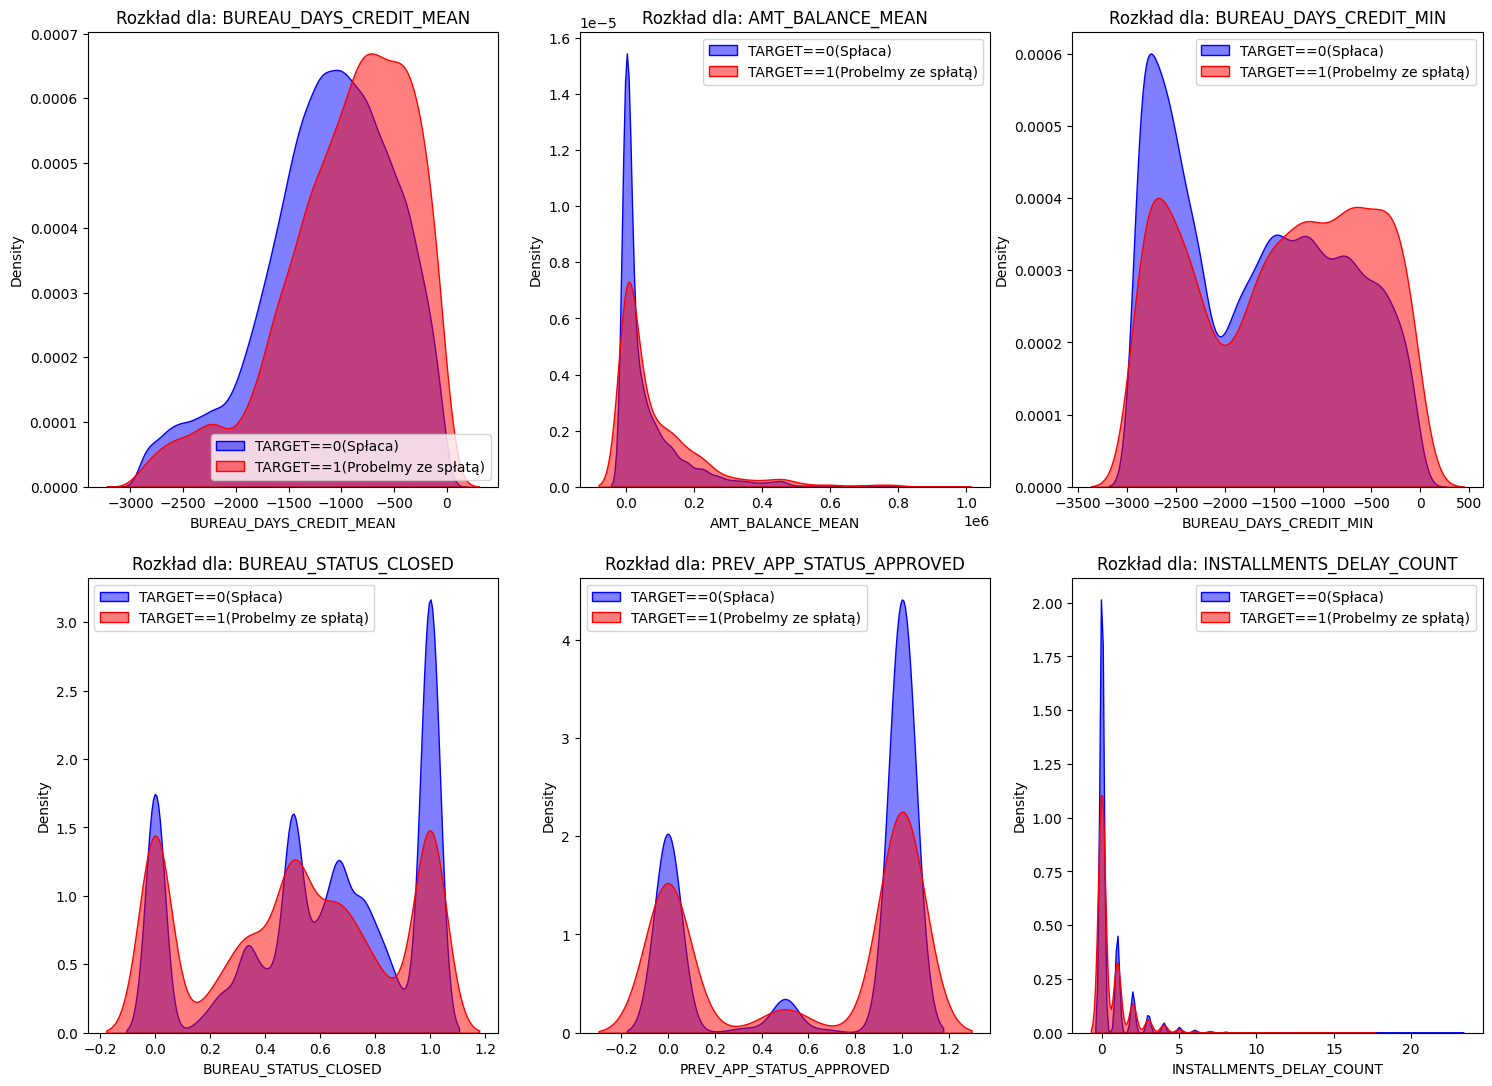

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

In [ ]:
features_to_plot = [
    'BUREAU_DAYS_CREDIT_MEAN',
    'AMT_BALANCE_MEAN',
    'BUREAU_DAYS_CREDIT_MIN',
    'BUREAU_STATUS_CLOSED',
    'PREV_APP_STATUS_APPROVED',
    'INSTALLMENTS_DELAY_COUNT',
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 13))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
  ax = axes[i]
  plt.figure(figsize=(7,5))
  sns.kdeplot(X_train_raw_transformed.loc[X_train_raw_transformed['TARGET']==0, feature].dropna(),
              label='TARGET==0(Spłaca)', fill=True, color='blue', alpha=0.5, ax=ax)
  sns.kdeplot(X_train_raw_transformed.loc[X_train_raw_transformed['TARGET']==1, feature].dropna(),
              label='TARGET==1(Probelmy ze spłatą)', fill=True, color='red', alpha=0.5, ax=ax)
  ax.set_title(f'Rozkład dla: {feature}')
  ax.set_label('')
  ax.legend()
plt.tight_layout()
plt.show()

**Wykres numer jeden dla cechy BUREAU_DAYS_CREDIT_MEAN-średnia ilosc dni po jakiej klient ubiegał sie o kredyt po poprzednim wniosku/kredycie:**

Rozkłady niemal identyczne z lekkim przesunięciem rozkładu gęstości dla osób które mają probelmy ze spłatą w strone wartości zero na osi x, co odzwierciedla słąbą korelacje na poziomie 0.07, co potwierdza, że osoby które w krótszym czasie od udzielenia poprzedniego kredytu ubiegją sie o nowy mają większe problemy ze spłatą.

**Wykres numer dwa dla cechy AMT_BALANCE_MEAN-średnie saldo zadłużenia na karacie kredytowej klienta:**

Mimo podobenstwa rozkladow wierzcholek rozkladu dla klientow splacajacyh swoje zadluzenie (niebieski wykres) jest wyzszy niz czerwony w rejonie malych wartosci zadluzenia karty, co oznacza ze wiekszy odsetek klientow ktorzy spłacają swoje zadłuzenia i nie ma z nimi problemów, utrzymuje swoje zadłużenie karty na niskim lub zerowym poziomie. Czerwony wykres symbolizujący klientów z problemami opada znacznie wolnej i ma gruby ogon po prawej stronie. Oznacza to, że wśród klientów z problemami (TARGET=1) jest znacznie większe prawdopodobieństwo znalezienia osób z chronicznie wysokim zadłużeniem na karcie

**Wykres numer trzy dla cechy BUREAU_DAYS_CREDIT_MIN-najsarszy kredyt w historii klienta/historia bankowa klienta:**

Na wykresie widac ze rozklad dla osob bez problemow ze splata ma wiekszy wierzchołek po lewej stronie co oznacza ze wiekszy odsetek klientów którzy spłacają bez problemowe swoje zadluzenia to klienci z długą historią bankową. Czerwony wykres ma nizszy wierzchołek przy duzych wartosciach ujemnych i gruby ogon w prawa strone wykresu co oznacza ze wiekszy odsetek osob ktore maja problemy ze splata to osoby z krótką historią kredytową.

**Wykres numer cztery dla cechy BUREAU_STATUS_CLOSED-proporcja(odsetek) wszystkich zamkniętych kredytów klienta:**

na wykresie widac ze wyzszy wierzcholek niebieski reprezentujacy klientow ktorzy nie maja problemów ze spłatą znajduje sie po prawej stronie co oznacza ze wsrod klientow ktorzy splacaja jest wiekszy odsetek klientow ktorzy maja swoje kredyty zamkniete, gdzie dla klientow z problemami ze splata wykres idzie bardziej w lewo co oznacza ze wiekszy odsetek tych klientow to klienic ktorzy maja np wiecej otwartych kredytow niz zamknietych


Wykres dla PREV_APP_STATUS_APROVED czyli odsetek wnioskow złozonych przez klienta które zakończyły sie sukcesem:

Na wykresie widac że dla klientow którzy spłacją (niebiescy) mamy wyzszy wierzchołek po prawej stornie co oznacza ze wsrod tych kliento jest wiecej osob ktore otrzymały kredytow proporcjalnie do ilosci zlozonych wnioskow, wykres dla klientow z problemami rozciaga sie w lewa strone co oznacza ze wsrod klientow ktorzy maja problem ze splata jest gorszy stosunek zlozonych wniskow do otrzymanych kredytów.

Wykres dla INSTALLMENTS_DELAY_COUNT:
Wykresy prawie identyczne, jednak wyzszy wierzchołek dla klientow z target 0 czyli wiekszy odestek tych klientow splaca swoje zobowiaania bez opoznien gdzie dla kliento z target 1 czyli z problemami , wykres ma ogon w prawa strone co oznacza ze wsrod tych klientow jest wieksza tendencja do poznien w splatach rat.


<Axes: >

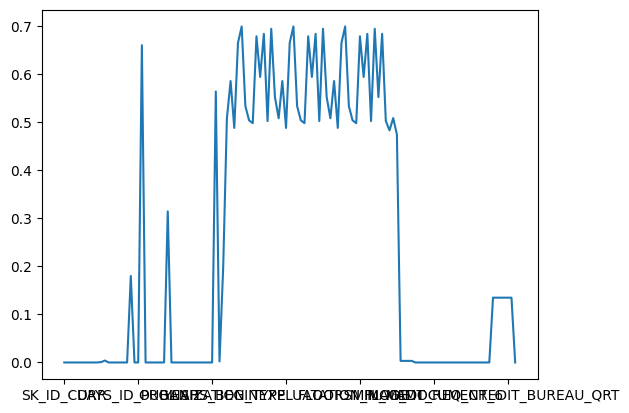

In [ ]:
X_train.isna().mean().plot()

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194129 entries, 0 to 194128
Columns: 123 entries, SK_ID_CURR to DAYS_EMPLOYED_ANOM
dtypes: bool(1), float64(103), int64(3), object(16)
memory usage: 180.9+ MB


In [ ]:
y_train = X_train['TARGET']
X_train = X_train.drop(columns='TARGET', axis=1)

In [ ]:
bool_ = X_train.select_dtypes(include='bool')

In [ ]:
bool_

,DAYS_EMPLOYED_ANOM
0,False
1,False
2,False
3,False
4,False
...,...
194124,False
194125,False
194126,False
194127,True


In [ ]:
y_train2 = X_train2['TARGET']
X_train2 = X_train2.drop(columns='TARGET', axis=1)

In [ ]:
cols_from_transformer = ['AMT_BALANCE_MEAN', 'AMT_BALANCE_MAX', 'ATM_DRAWNINGS_RATIO_MEAN', 'ATM_DRAWNINGS_RATIO_MAX', 'SK_DPD_MEAN',
                         'SK_DPD_MAX', 'SK_DPD_COUNT', 'PAYMENT_DIFFERENCE_MEAN','PAYMENT_DIFFERENCE_MAX','PAYMENT_DIFFERENCE_COUNT',
                         'INSTALLMENTS_DELAY_MEAN', 'INSTALLMENTS_DELAY_MAX', 'INSTALLMENTS_DELAY_COUNT', 'INSTALLMENTS_DIFFERENCE_MEAN',
                          'INSTALLMENTS_DIFFERENCE_MAX', 'INSTALLMENTS_DIFFERENCE_COUNT', 'PREV_APP_AMT_APPLICATION_MEAN', 'PREV_APP_AMT_APPLICATION_MAX',
                         'BUREAU_DAYS_CREDIT_MIN', 'BUREAU_DAYS_CREDIT_MAX', 'BUREAU_DAYS_CREDIT_MEAN', 'BUREAU_AMT_CREDIT_SUM_SUM',
                         'BUREAU_AMT_CREDIT_SUM_MEAN', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN']

binary_cols = ['DAYS_EMPLOYED_ANOM']
numeric_cols = [col for col in X_train2.select_dtypes(include=np.number).columns if col not in cols_from_transformer and col not in binary_cols and col != 'SK_ID_CURR']
obj_cols = X_train2.select_dtypes(include=['object', 'category']).columns

In [ ]:
obj_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [ ]:
cols_from_transformer

['AMT_BALANCE_MEAN',
 'AMT_BALANCE_MAX',
 'ATM_DRAWNINGS_RATIO_MEAN',
 'ATM_DRAWNINGS_RATIO_MAX',
 'SK_DPD_MEAN',
 'SK_DPD_MAX',
 'SK_DPD_COUNT',
 'PAYMENT_DIFFERENCE_MEAN',
 'PAYMENT_DIFFERENCE_MAX',
 'PAYMENT_DIFFERENCE_COUNT',
 'INSTALLMENTS_DELAY_MEAN',
 'INSTALLMENTS_DELAY_MAX',
 'INSTALLMENTS_DELAY_COUNT',
 'INSTALLMENTS_DIFFERENCE_MEAN',
 'INSTALLMENTS_DIFFERENCE_MAX',
 'INSTALLMENTS_DIFFERENCE_COUNT',
 'PREV_APP_AMT_APPLICATION_MEAN',
 'PREV_APP_AMT_APPLICATION_MAX',
 'BUREAU_DAYS_CREDIT_MIN',
 'BUREAU_DAYS_CREDIT_MAX',
 'BUREAU_DAYS_CREDIT_MEAN',
 'BUREAU_AMT_CREDIT_SUM_SUM',
 'BUREAU_AMT_CREDIT_SUM_MEAN',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN']

In [ ]:
numeric_cols

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXP

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_trans_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

obj_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, numeric_cols),
    ('num_trans_pipeline', num_trans_pipeline, cols_from_transformer),
    ('obj_pipeline', obj_pipeline, obj_cols),
    ('binary_passthrough', 'passthrough', binary_cols)
],
 remainder='drop'
 )

main_pipeline = Pipeline([
    ('transformator', CustomTransformator()),
    ('preprocessor', preprocessor)
])

In [ ]:
models = {
    'logistic_regression': LogisticRegression(max_iter=100),
    'random_forest' : RandomForestClassifier(random_state=42),
    'lgbm': LGBMClassifier(random_state=42),
    'xgb': XGBClassifier(random_state=42, use_label_encoder=False, eval_metrics='logloss')
}

for name, model in models.items():
  final_pipeline = Pipeline([
      ('main_pipeline', main_pipeline),
      ('model', model)
  ])
  score = cross_val_score(final_pipeline, X_train2, y_train2,cv=5, scoring='roc_auc', n_jobs=-1)
  print(f'Model: {name}')
  print(f'Średni wynik AUC: {score.mean():.4f} +/- {score.std():.4f}')

Model: logistic_regression
Średni wynik AUC: 0.7454 +/- 0.0034
Model: random_forest
Średni wynik AUC: 0.7059 +/- 0.0054
Model: lgbm
Średni wynik AUC: 0.7528 +/- 0.0046
Model: xgb
Średni wynik AUC: 0.7402 +/- 0.0048


Jako model do dalszej ewaulacji wybieram LGBMClassifier poniewaz wykazał sie najlepszym wynikiem AUC. Wynik ten na poziomie 0.7457 oznacza ze jesli model mialby sklasyfikowac klienta z ryzykownego i klienta ktory spłaca to z szansą ok.75% umieści poprawnie tego ryzykownego w grupie podwyższonego ryzyka.

In [ ]:
import json
import joblib

def objective(trial):
  params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
  }
  model = LGBMClassifier(**params)
  model_pipeline = Pipeline([
      ('main_pipeline', main_pipeline),
      ('model', model)
  ])
  scores = cross_val_score(model_pipeline, X_train2, y_train2, cv=3, scoring='roc_auc', n_jobs=-1)
  return np.mean(scores)


study_name = 'lgbm-home-credit-tuning'
storage_name = f"sqlite:///{study_name}.db"

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction='maximize'
)


study.optimize(objective, n_trials=50, n_jobs=-1)

print("\n Optymalizacja zakończona!")
print(f"Najlepszy wynik AUC: {study.best_value:.4f}")

best_params = study.best_params
print("Najlepsze znalezione parametry:", best_params)
with open('best_lgbm_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)
print("Zapisano parametry do 'best_lgbm_params.json'")

final_model = LGBMClassifier(**best_params)
final_pipeline = Pipeline(steps=[
    ('preprocessing', main_pipeline),
    ('model', final_model)
])
final_pipeline.fit(X_train2, y_train2)
joblib.dump(final_pipeline, 'final_model_pipeline.joblib')
print("✅ Finalny, wytrenowany model zapisany do 'final_model_pipeline.joblib'")


'\nimport json\nimport joblib\n\ndef objective(trial):\n  params = {\n        \'objective\': \'binary\',\n        \'metric\': \'auc\',\n        \'verbosity\': -1,\n        \'random_state\': 42,\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 200, 2000, step=100),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.2),\n        \'num_leaves\': trial.suggest_int(\'num_leaves\', 20, 300),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 12),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 20, 200),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.6, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.6, 1.0),\n  }\n  model = LGBMClassifier(**params)\n  model_pipeline = Pipeline([\n      (\'main_pipeline\', main_pipeline),\n      (\'model\', model)\n  ])\n  scores = cross_val_score(model_pipeline, X_train2, y_train2, cv=3, scoring=\'roc_auc\', n_jobs=-1)\n  return np.mean(scor

rezygnuje z oczekiwania na optune na rzecz efektywniejszego przeszukiwania jakim jest połączenie RandomizedSearchCV do zawężenia obszaru poszuiwania a następnie użycie GridSearchCV do dokładniejszego przeszukania wąskiego obszaru w celu znalezienia najelpszych dla naszego problemu hiperparametrów.

In [ ]:
from scipy.stats import randint, uniform

model = LGBMClassifier(random_state=42)
model_pipeline = Pipeline([
    ('preprocessing', main_pipeline),
    ('model', model)
])
param_dist = {
    # Kluczowe parametry struktury drzew
    'model__n_estimators': randint(300, 2000),  # Liczba drzew. Szeroki zakres do eksploracji.
    'model__num_leaves': randint(20, 250),      # Główny parametr kontrolujący złożoność.
    'model__max_depth': randint(3, 15),         # Tradycyjna głębokość, ogranicza num_leaves.
    'model__min_child_samples': randint(20, 200),# Minimalna liczba próbek w liściu, działa jak regularyzacja.

    # --- Parametry procesu uczenia ---
    'model__learning_rate': uniform(0.01, 0.19), # Szybkość uczenia. uniform(0.01, 0.19) da wartości z przedziału [0.01, 0.2).

    # --- Parametry regularyzacji (walka z przeuczeniem) ---
    'model__subsample': uniform(0.6, 0.4),       # Procent wierszy używany do budowy każdego drzewa (Bagging). uniform(0.6, 0.4) da wartości z [0.6, 1.0).
    'model__colsample_bytree': uniform(0.6, 0.4),# Procent kolumn (cech) używany do budowy każdego drzewa.
    'model__reg_alpha': uniform(0, 10),          # Regularyzacja L1.
    'model__reg_lambda': uniform(0, 10),         # Regularyzacja L2.

    # --- Stałe parametry ---
    'model__objective': ['binary'],             # Problem klasyfikacji binarnej.
    'model__metric': ['auc'],                   # Metryka do optymalizacji.
    'model__random_state': [42],
    'model__n_jobs': [-1]
}

rnd_search = RandomizedSearchCV(estimator=model_pipeline,
                                param_distributions=param_dist,
                                n_iter=50,
                                scoring='roc_auc',
                                cv=3,
                                verbose=2,
                                random_state=42,
                                n_jobs=1)
rnd_search.fit(X_train_sample, y_train_sample)
print(f'Najlepsze znalezione parametry: {rnd_search.best_params_}')
print(f'Najlepszy wynik: {rnd_search.best_score_:.4f}')

"from scipy.stats import randint, uniform\n\nmodel = LGBMClassifier(random_state=42)\nmodel_pipeline = Pipeline([\n    ('preprocessing', main_pipeline),\n    ('model', model)\n])\nparam_dist = {\n    # Kluczowe parametry struktury drzew\n    'model__n_estimators': randint(300, 2000),  # Liczba drzew. Szeroki zakres do eksploracji.\n    'model__num_leaves': randint(20, 250),      # Główny parametr kontrolujący złożoność.\n    'model__max_depth': randint(3, 15),         # Tradycyjna głębokość, ogranicza num_leaves.\n    'model__min_child_samples': randint(20, 200),# Minimalna liczba próbek w liściu, działa jak regularyzacja.\n\n    # --- Parametry procesu uczenia ---\n    'model__learning_rate': uniform(0.01, 0.19), # Szybkość uczenia. uniform(0.01, 0.19) da wartości z przedziału [0.01, 0.2).\n\n    # --- Parametry regularyzacji (walka z przeuczeniem) ---\n    'model__subsample': uniform(0.6, 0.4),       # Procent wierszy używany do budowy każdego drzewa (Bagging). uniform(0.6, 0.4) da w

In [ ]:
default_model = LGBMClassifier(random_state=42, n_jobs=-1)

final_pipeline = Pipeline([
    ('main_pipeline', main_pipeline),
    ('model', default_model)
])
final_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 15772, number of negative: 178357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16518
[LightGBM] [Info] Number of data points in the train set: 194129, number of used features: 263
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081245 -> initscore=-2.425551
[LightGBM] [Info] Start training from score -2.425551


Pipeline(steps=[('main_pipeline',
                 Pipeline(steps=[('transformator', CustomTransformator()),
                                 ('preprocessor',
                                  ColumnTransformer(transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['CNT_CHILDREN',
                                                                    'AMT_INCOME_TOTAL',
                                                                    'AMT_CREDIT',
                                                                    'AMT_ANNUITY',
                                                                    'AMT_GOODS_PRICE',
                                                                    'REGION_POPULATION_RELATIV...
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')),
                                                                  ('binary_passthrough',
                                                                   'passthrough',
                                                                   ['DAYS_EMPLOYED_ANOM'])]))])),
                ('model', LGBMClassifier(n_jobs=-1, random_state=42))])

In [ ]:
score = cross_val_score(final_pipeline, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
print(f'Wynik roc auc: {score.mean():.4f}')

Wynik roc auc: 0.7528


In [ ]:
y_scores = cross_val_predict(final_pipeline, X_train, y_train, cv=3, method='predict_proba', n_jobs=-1)

In [ ]:
y_pred_proba = y_scores[:, 1]

In [ ]:
y_pred_proba

array([0.37699741, 0.03130807, 0.03550028, ..., 0.21093995, 0.06226971,
       0.06271903])

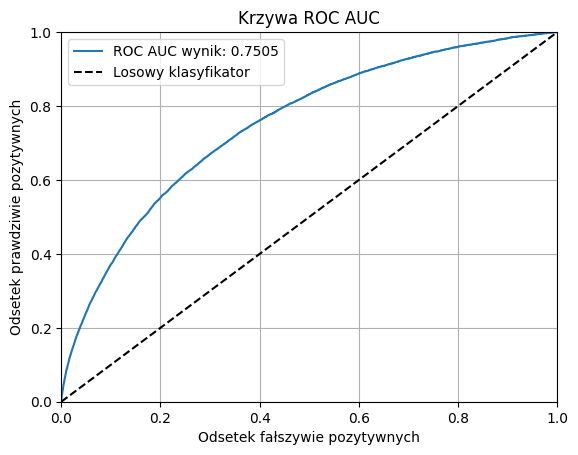

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train2, y_pred_proba)
auc_score = roc_auc_score(y_train2, y_pred_proba)

plt.plot(fpr, tpr, label=f'ROC AUC wynik: {auc_score:.4f}')
plt.plot([0,1], [0, 1], 'k--', label='Losowy klasyfikator')
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.axis([0, 1, 0, 1])
plt.title('Krzywa ROC AUC')
plt.legend()
plt.grid()
plt.show()

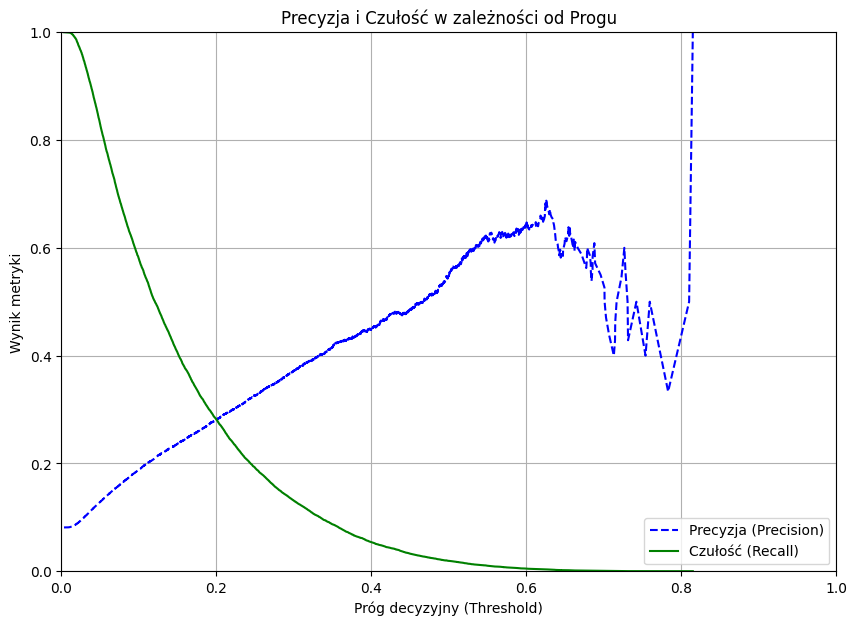

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(thresholds, precision[:-1], "b--", label="Precyzja (Precision)") # <--- POPRAWKA
plt.plot(thresholds, recall[:-1], "g-", label="Czułość (Recall)")      # <--- POPRAWKA
plt.xlabel("Próg decyzyjny (Threshold)")
plt.ylabel("Wynik metryki")
plt.title("Precyzja i Czułość w zależności od Progu")
plt.grid(True)
plt.legend()
plt.axis([0, 1, 0, 1])
plt.show()

W zależności od strategii biznesowej banku należałoby wybrać jedną z trzech opcji do ustawienia porgu decyzyjnego dla modelu:

-Nie tracic pieniedzy, kazdy splacony kredyt to katastrofa wtedy patrzymy na zieloną linie która symbolizuje czułość/recall i chcemy ustawic próg na takim poziomie aby była jka najwyżej np. 0.1, spowoduje to że model wyłapie 0.7-0.9 ryzykownych klientów przy niskiej precyzji co oznacza, że wielu klientów uznanych za ryzykownych będą to fałszywe alaramy.

-Ustawiamy próg na poziomie np. 0.6 wtedy mamy wysoką precyzje co skutkuje tym ze jesli model juz kogos oflaguje jak ryzykownego to mamy wysoką pewność ze faktycznie tak jest przy jednoczesnej stracie dla czułości, wiele zatwierdzonych kredytów zostanie błędnie zatwierdzonych.

-Można też wybrać prog na punkcie przecięcia dwóch krzywych. Wtedy zdolność do łapania klientów jest mnie jwięcej na pozioie naszej pewności. Uzyskujemy w ten spoób zrównoważony system, tracimy przy tym na czułości i precyzji, nasz model jest dobry w obu.




In [ ]:
y_test_pred = final_pipeline.predict_proba(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
y_test_submission = y_test_pred[:, 1]

In [ ]:
X_test['SK_ID_CURR']

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038
...,...
48739,456221
48740,456222
48741,456223
48742,456224


In [ ]:
submission_df = pd.DataFrame({
    'SK_ID_CURR': X_test['SK_ID_CURR'],
    'TARGET' : y_test_submission
})

In [ ]:
submission_df.to_csv('submission_home_credit.csv', index=False)

In [ ]:
model = final_pipeline.named_steps['model']
explainer = shap.TreeExplainer(model)

In [ ]:
X_train_sample = X_train.sample(n=5000, random_state=42)
X_train_sample_transformed = main_pipeline.transform(X_train_sample)

In [ ]:
column_transformer_step = main_pipeline.named_steps['preprocessor']
features_names = column_transformer_step.get_feature_names_out()

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


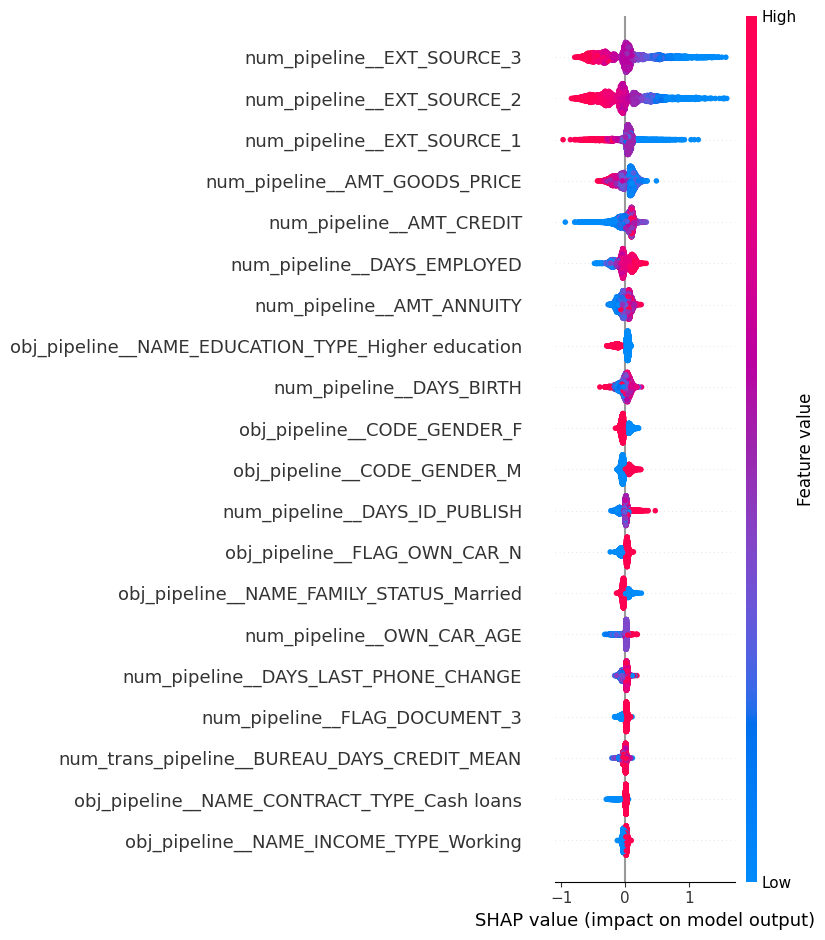

In [ ]:
shap_values = explainer.shap_values(X_train_sample_transformed)
shap.summary_plot(shap_values, X_train_sample_transformed, feature_names=features_names)

Jak widać na wykresie wpływu cech na predykcje modelu możemy zauważyc że najsilniejszym predyktorami tego czy klient jest klientem ryzykownym były wartości scoringów kredytowych jak EXT_SOURCE3-1. Im mniejsza wartośc dla tych scoringów tym większa szansa że klient zostanie zakfalifikowany jako klient ryzykowny i nie zostanie mu udzielona pożyczka. Zgodnie z postawioną hipotezą mają one najwiekszy wpływ na ocene modelu.